In [1]:
import numpy as np
import sipm.sipm as sipm
import sipm.dataset as ds
import sipm.beta as beta
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sipm.constants as const
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Scintillation data bottom 1107

In [2]:
# dir1007 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/"
# subdir1007 = ["2022-10-07_volt_65_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_67_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_69_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_71_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_73_pos_top_light_scint_coinc_111",
#               "2022-10-07_volt_75_pos_top_light_scint_coinc_111"]
# dscrp1007 = ["65V", "67V", "69V", "71V", "73V", "75V"]
# bias = [65, 67, 69, 71, 73, 75]

# dir1104_bg = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-04/2022-11-04_volt_70_pos_bottom_light_scintillation_coinc_111_cond_no_gamma'
# dir1104_cs = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-04/2022-11-04_volt_70_pos_bottom_light_scintillation_coinc_111_cond_with_gamma'

dir1107_bkg = []
dir1107_gamma = []
for i in range(5):
    dir1107_bkg.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_no_gamma_purification_{}'.format(i+1))
    dir1107_gamma.append('/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-07/2022-11-07_volt_65_pos_bottom_light_scintillation_coinc_111_cond_with_gamma_purification_{}'.format(i+1))


In [3]:
ds1107_bkg = []
ds1107_gamma = []
for i,subdir in enumerate(dir1107_bkg+dir1107_gamma):
    data = ds.Dataset('', pol=-1, channels=range(4), spe=[518.84503, 510.84132, 504.40531, 457.59589])
    for j in range(10):
        data.path = "{}/{}/".format(subdir, j)
        if j<=6 or i!=4:
            for ch in range(4):
                data.ch[ch].path = data.path
                data.ch[ch].read_data()
                data.ch[ch].baseline_subtraction()
                data.ch[ch].get_avgwf()
                data.ch[ch].get_integral(prompt=0.5, long=5)
                data.ch[ch].clear()
    data.get_summed_integral_pe()
    data.get_fprompt()
    if i<len(dir1107_bkg):
        ds1107_bkg.append(data)
    else:
        ds1107_gamma.append(data)

## $f_{\rm prompt}$ distribution
Prompt integral = $0.5~\rm{\mu s}$ integrated charge
Total integral = $5~\rm{\mu s}$ integrated charge

Text(0.5, 0.98, 'Cs-137 + Backgrounds')

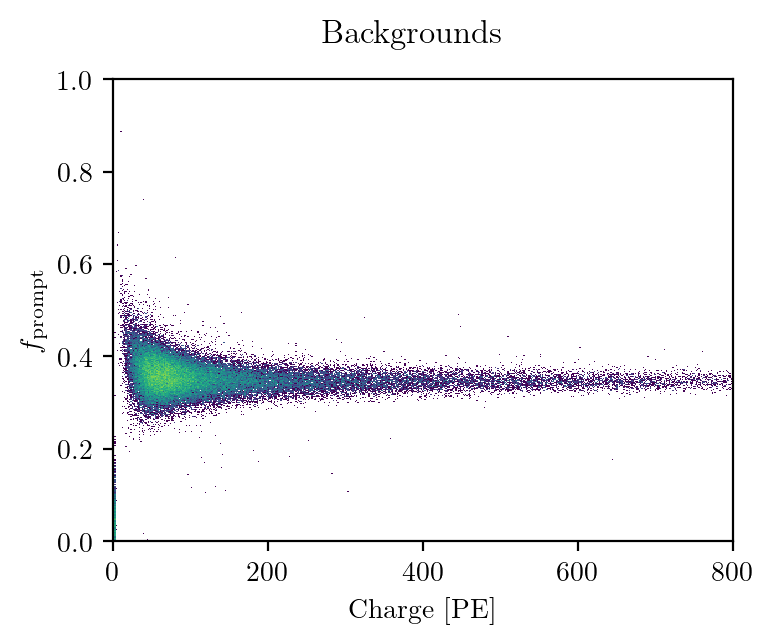

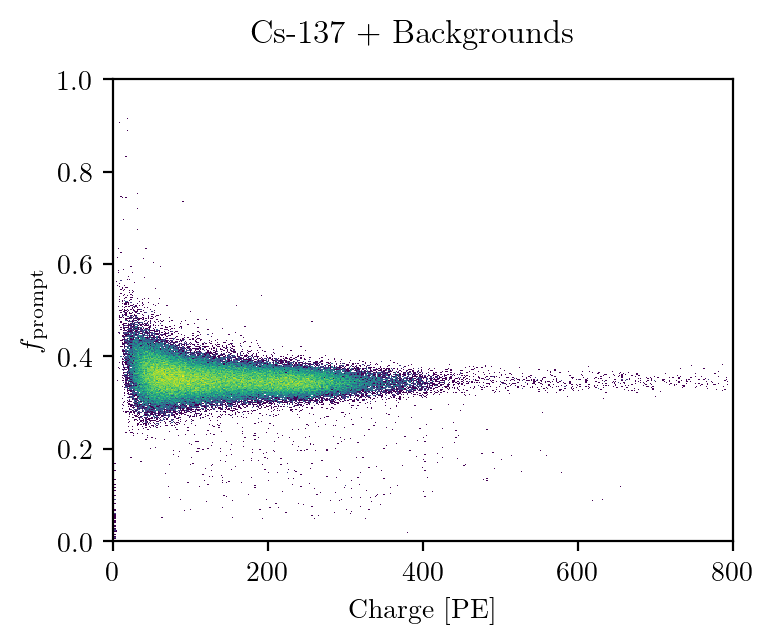

In [7]:
import matplotlib.colors as colors
plt.figure(0)
dset = ds1107_bkg[0]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[500,500], range=[[0,800],[0,1]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Backgrounds')
plt.figure(1)
dset = ds1107_gamma[0]
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[500,500], range=[[0,800],[0,1]], norm = colors.LogNorm())
plt.xlabel('Charge [PE]')
plt.ylabel(r'$f_{\rm prompt}$')
plt.suptitle('Cs-137 + Backgrounds')

## Spectrum of $5~\rm{\mu s}$ integrated charge

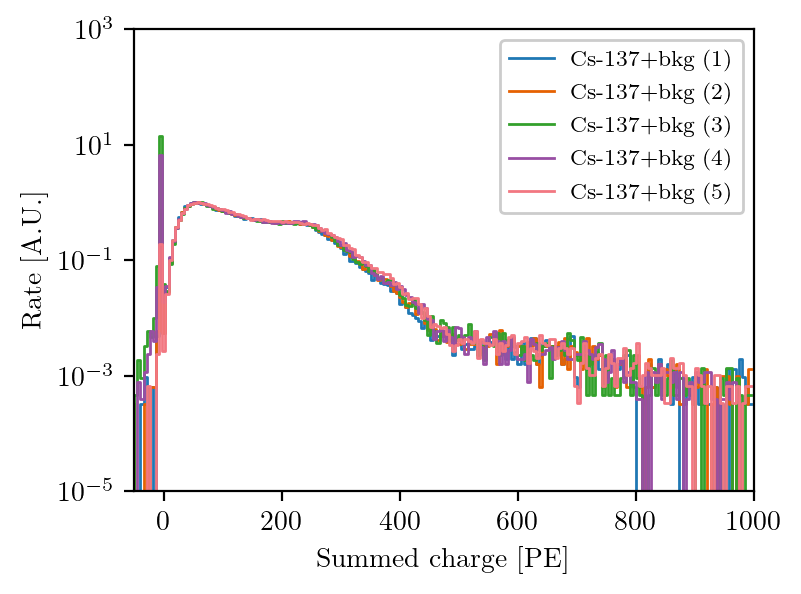

In [11]:
xmin = -50
xmax = 1000
nbins = 200
bin_width = (xmax-xmin)/nbins
labels = []
for i in range(len(ds1107_gamma)):
    labels.append('Cs-137+bkg ({})'.format(i+1))
plt.figure()
hist = []
for i in range(len(ds1107_gamma)):
    ds = ds1107_gamma[i]
    h,hx = np.histogram(ds.summed_integral_pe, bins=np.linspace(xmin,xmax,nbins))
    h = h/np.max(h[20:])
    #h = h/ds.ch[0].cumulative_time/bin_width
    hist.append(h)
    plt.step(hx[:-1], h, label=labels[i], linewidth=1)
# plt.step(hx[:-1], hist[1]-hist[0], label='difference', linewidth=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-5, 1e3)
plt.xlabel('Summed charge [PE]')
plt.ylabel('Rate [A.U.]')
plt.show()

## Triplet lifetime

ch0 A_S=293.393+/-3.478  TAU_S=0.0632+/-0.0010us  A_T=38.629+/-0.476  TAU_T=0.8433+/-0.0088us
ch1 A_S=335.249+/-3.299  TAU_S=0.0894+/-0.0012us  A_T=33.925+/-0.514  TAU_T=1.3804+/-0.0198us
ch2 A_S=325.727+/-3.350  TAU_S=0.0825+/-0.0012us  A_T=35.971+/-0.518  TAU_T=1.1649+/-0.0147us
ch3 A_S=261.943+/-2.459  TAU_S=0.0877+/-0.0011us  A_T=26.379+/-0.341  TAU_T=1.6468+/-0.0220us


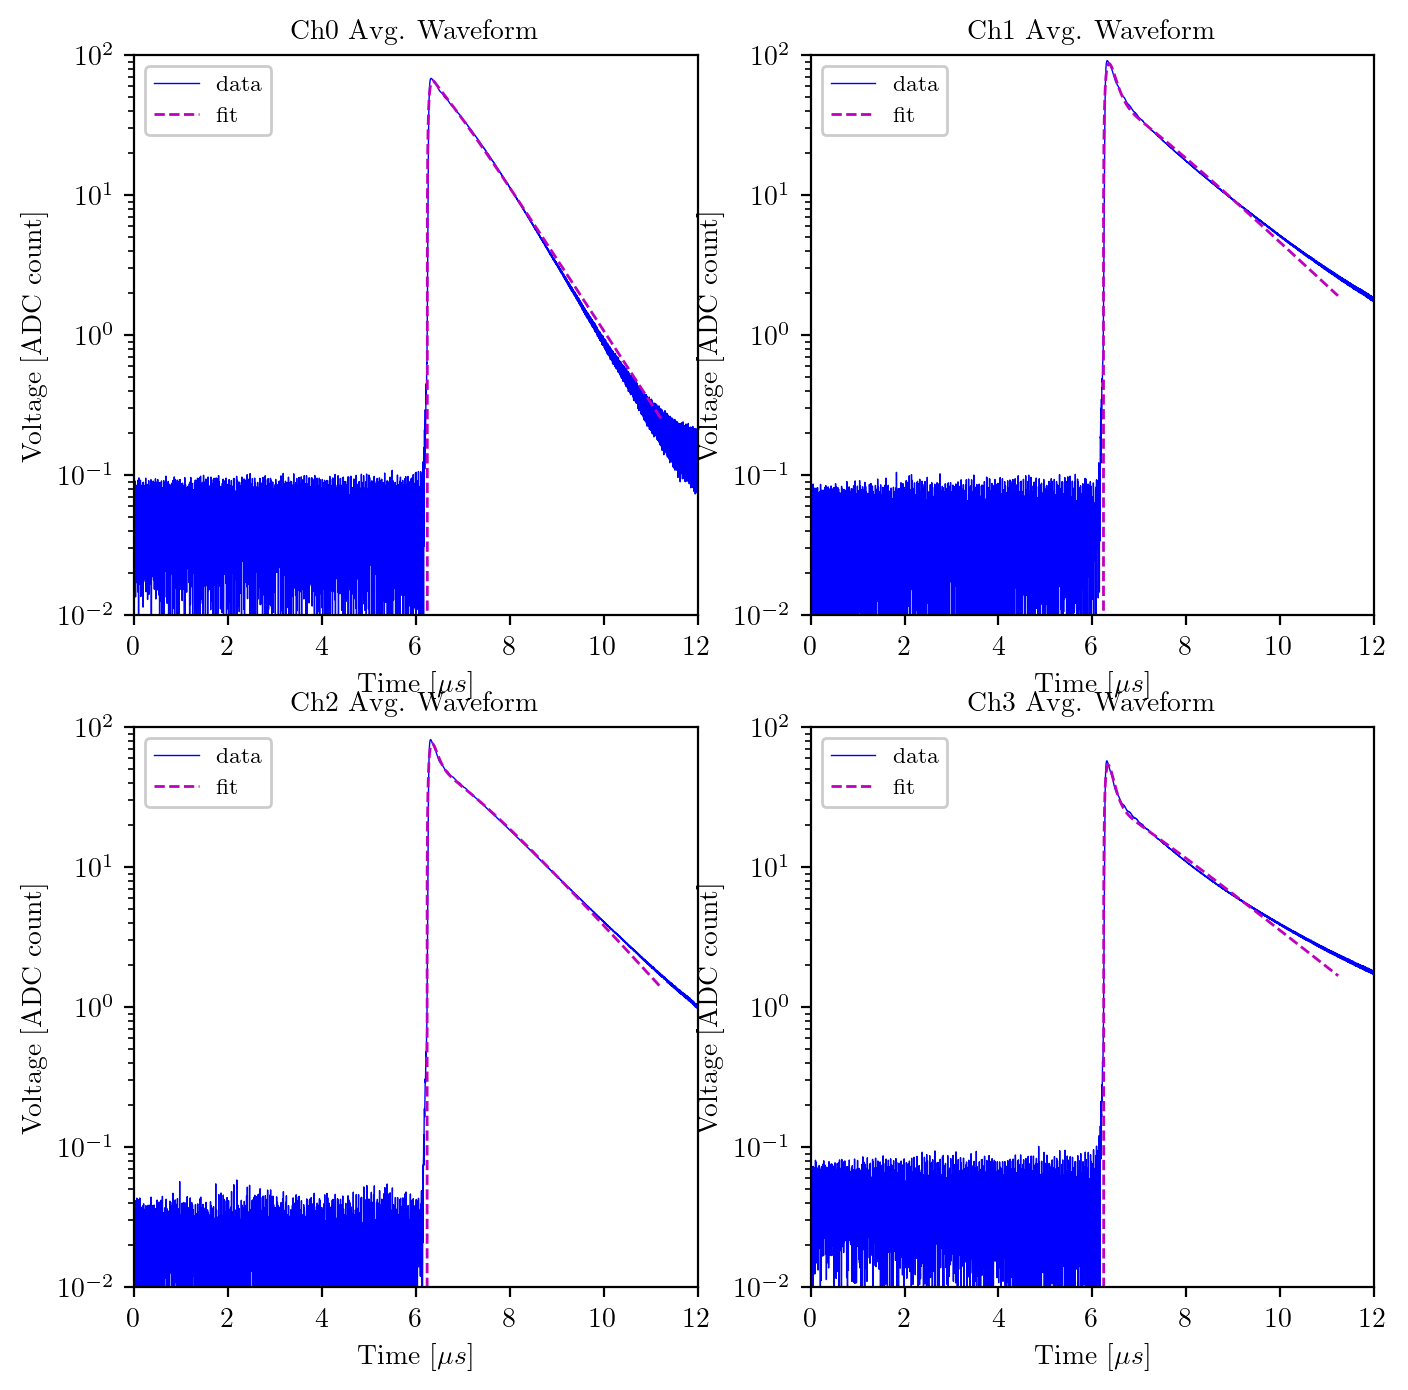

In [12]:
plt.figure(0,figsize=(8,8))
colors = ['r','b','g','m']
A1 = [2.87034549074171, 4.56530440419285, 4.34100691988196, 4.6130995887607]
TAU1 = [0.0444273100352291, 0.101583182633407, 0.07246236377296, 0.0718649983147296]
A2 = [3.02004825336753, 1.03860477405824, 1.42205954757012, 0.783024106669865]
TAU2 = [0.39793842757296, 0.733531780706409, 0.702539511527978, 0.710143874389766]

dset = ds1107_gamma[0]
for ch in range(4):
    dset.ch[ch].set_pulse_pars(a1=A1[ch], tau1=TAU1[ch], a2=A2[ch], tau2=TAU2[ch])
    plt.subplot(2,2,ch+1)
    plt.plot(dset.ch[ch].time, abs(dset.ch[ch].avgwf), "b-", label='data', linewidth=0.5)      
    t0 = dset.ch[ch].trigger_position
    length = int(5/dset.ch[ch].sample_step)
    err = np.std(dset.ch[ch].avgwf[:t0])
    popt,pcov = curve_fit(dset.ch[ch].get_scintillation, dset.ch[ch].time[t0:t0+length], abs(dset.ch[ch].avgwf[t0:t0+length]), p0=[300, 0.05, 40, 1.2], sigma=[err]*length, maxfev=10000)
    print('ch{} A_S={:.3f}+/-{:.3f}  TAU_S={:.4f}+/-{:.4f}us  A_T={:.3f}+/-{:.3f}  TAU_T={:.4f}+/-{:.4f}us'.format(ch,popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3])))
    dset.ch[ch].tau_singlet = [popt[1], np.sqrt(pcov[1,1])]
    dset.ch[ch].tau_triplet = [popt[3], np.sqrt(pcov[3,3])]
    plt.plot(dset.ch[ch].time[t0:t0+length], dset.ch[ch].get_scintillation(dset.ch[ch].time[t0:t0+length], *popt), "m--", label='fit', linewidth=1.0)
    
for ch in range(4):
    plt.subplot(2,2,ch+1)
    plt.title('Ch{} Avg. Waveform'.format(ch))
    plt.ylabel('Voltage [ADC count]')
    plt.xlabel(r'Time [$\mu s$]')
    plt.legend()
    plt.xlim(0,12)
    plt.ylim(1e-2, 100)
    plt.yscale('log')

# plt.figure(1, figsize=(3,3))
# for ch in range(4):
#     plt.errorbar(np.arange(5), [dset_.ch[ch].tau_triplet[0] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[0]], yerr=[dset_.ch[ch].tau_triplet[1] for dset_ in ds1006]+[dset.ch[ch].tau_triplet[1]], label='ch{}'.format(ch))
# plt.xlim(-1, 5)
# plt.ylim(1, 1.7)
# plt.legend()
# plt.ylabel(r'Triplet lifetime [$\mu s$]')
# plt.xticks(np.arange(5),labels=dscrp1006+['10-07'])